In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout #type: ignore
from sklearn.metrics import mean_squared_error
import math


2024-07-30 08:42:28.054120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 08:42:28.206156: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 08:42:28.340287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 08:42:28.468699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 08:42:28.506857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 08:42:28.723059: I tensorflow/core/platform/cpu_feature_gu

In [2]:

# Load the CSV data
df = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [3]:

# Filter the data for selected companies
companies = [
    'AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE',
    'EURO-CYCLES', 'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT',
    'SOMOCER', 'SOTETEL', 'SOTUVER', 'TUNISAIR',
    'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB'
]


In [4]:

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


In [5]:

# Prepare the data for all selected companies
dataframes = []
for company in companies:
    company_data = df[df['companyName'] == company].reset_index()['closingPrice']
    company_data = scaler.fit_transform(np.array(company_data).reshape(-1, 1))
    dataframes.append(company_data)


In [6]:

# Combine the data into a single array
combined_data = np.vstack(dataframes)


In [7]:

# Split the data into training and testing sets
training_size = int(len(combined_data) * 0.65)
train_data, test_data = combined_data[0:training_size, :], combined_data[training_size:len(combined_data), :1]


In [8]:

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [9]:

# Create datasets
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [10]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:

# Build the LSTM model with Dropout layers
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


/home/firas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0435 - val_loss: 0.0078
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0077 - val_loss: 0.0055
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

In [13]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [14]:

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [15]:

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 21.413517768979492
Test RMSE: 21.224467128872586


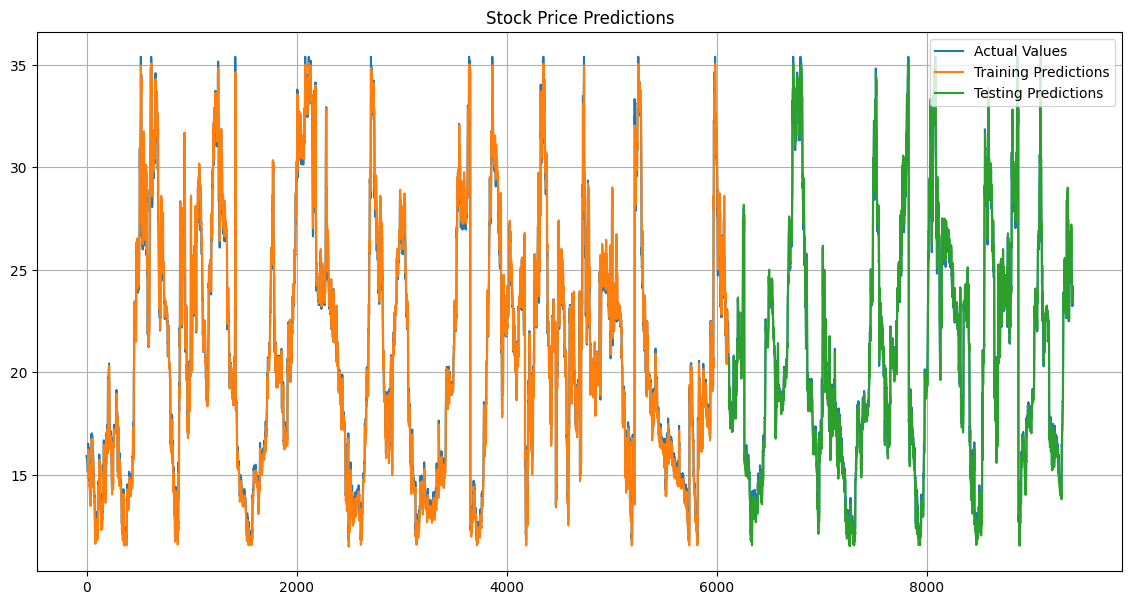

In [16]:

# Plotting
look_back = time_step
trainPredictPlot = np.empty_like(combined_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(combined_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(combined_data) - 1, :] = test_predict

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data), label='Actual Values')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.legend()
plt.grid(True)
plt.title('Stock Price Predictions')
plt.show()


In [17]:

# Predict the next 10 days
n_steps = 10
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
for i in range(10):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())


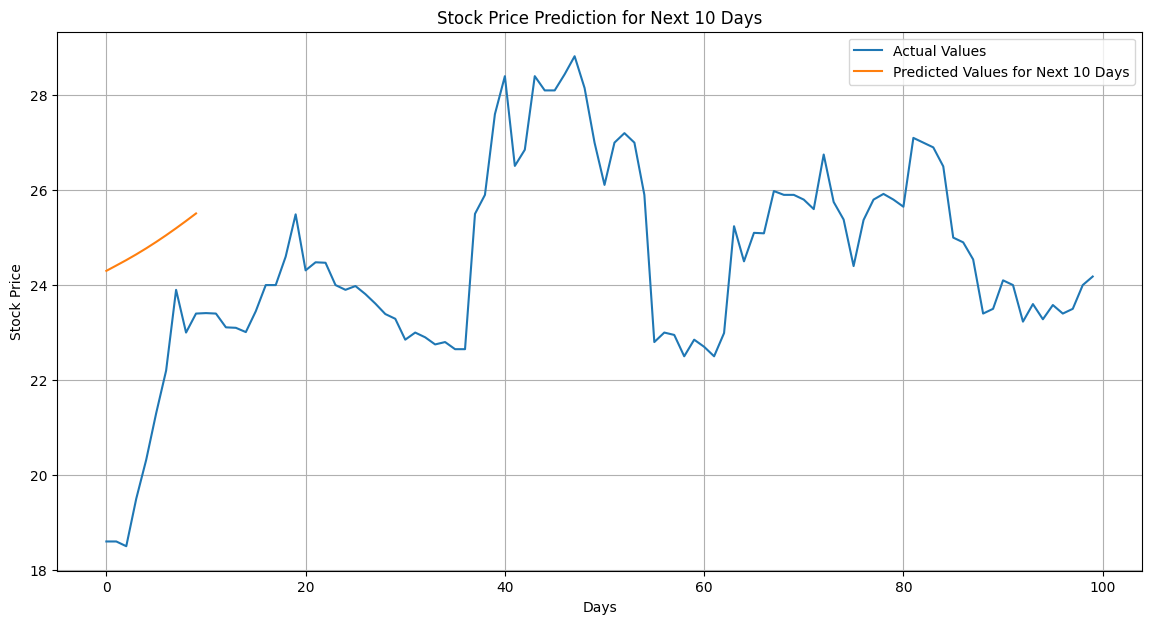

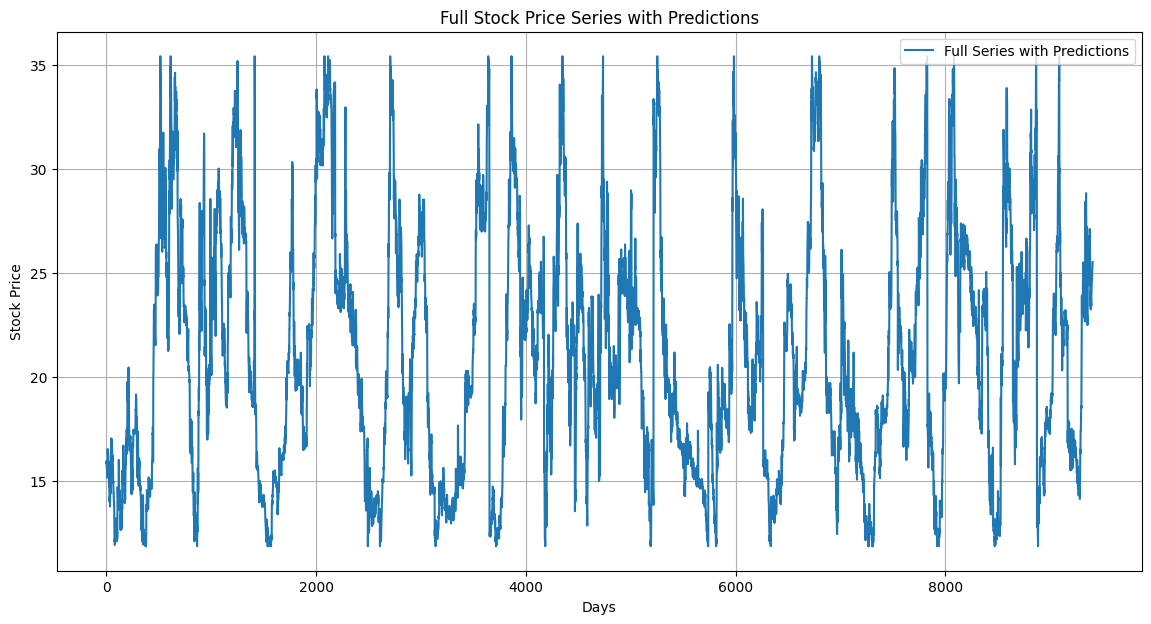

In [18]:

# Plot the last 100 actual values and the predicted values for the next 10 days
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data[len(combined_data)-100:]), label='Actual Values')
plt.plot(scaler.inverse_transform(lst_output), label='Predicted Values for Next 10 Days') # type: ignore
plt.title('Stock Price Prediction for Next 10 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Full visualization including all data points and predictions
stock_pred = combined_data.tolist()
stock_pred.extend(lst_output)
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(stock_pred), label='Full Series with Predictions')
plt.title('Full Stock Price Series with Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
